In our data, we do not have explicit ratings for game. In this notebook, I will check if it is possible to convert the playtimes into a certain scale, that we can treat as ratings.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import QuantileTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

We will use Quantile Transformer to turn the playtimes into a uniform distribution.

In [2]:
scaler = QuantileTransformer(random_state=0)

In [3]:
data = pd.read_parquet("../dat/steam_play.parquet")

In [4]:
data_ = data.set_index("userId")

We will exclude some of the users from our calculation, because there is not enough data to map their playtimes into a certain scale.

In [5]:
data_["counts"] = data.groupby("userId").count().game

In [6]:
data_ = data_.reset_index()

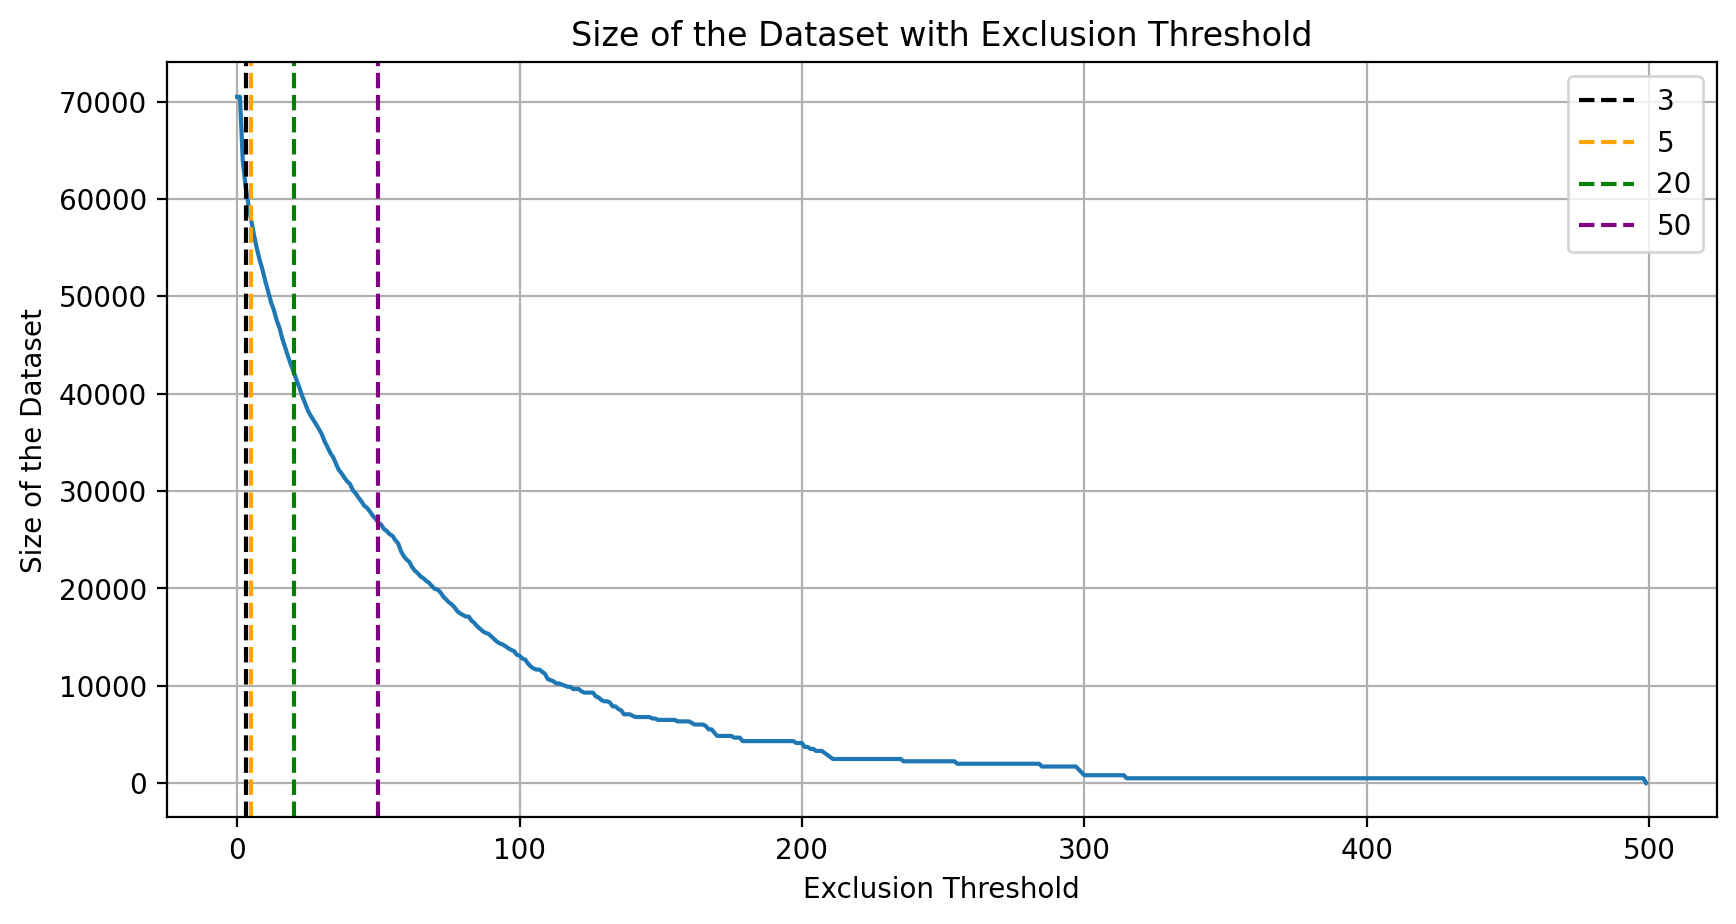

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=200)

ax.plot(list([len(data[data_.counts >= i])] for i in range(500)))
ax.set_title("Size of the Dataset with Exclusion Threshold")
ax.set_ylabel("Size of the Dataset")
ax.set_xlabel("Exclusion Threshold")
# ax.vlines([2, 5, 20, 50], ymin=0, ymax=70000, colors="orange")
ax.axvline(3, 0, 1, c="black", label="3", ls="--")
ax.axvline(5, 0, 1, c="orange", label="5", ls="--")
ax.axvline(20, 0, 1, c="green", label="20", ls="--")
ax.axvline(50, 0, 1, c="purple", label="50", ls="--")
ax.legend()
ax.grid()

plt.show()

Here, we see how the size of the dataset changes when we change the inclusion criteria. We put vertical lines at certain thresholds, 3, 5, 20 and 50, respectively. In recommender systems literature, it is suggested that we should use users with at least 20 to 50 ratings. However, this decreases the size of the dataset considerably. From here on out, we will be using threshold 3. So, a user needs to play at least 3 games before getting recommendations. Or similarly, users without at least 3 games won't be considered in our similarity graph.

In [8]:
cleaner_data = data[data_.counts >= 3]

In [9]:
cleaner_data

,userId,game,actionValue
0,151603712,The Elder Scrolls V Skyrim,273.0
1,151603712,Fallout 4,87.0
2,151603712,Spore,14.9
3,151603712,Fallout New Vegas,12.1
4,151603712,Left 4 Dead 2,8.9
...,...,...,...
70484,128470551,Fallen Earth,2.4
70485,128470551,Magic Duels,2.2
70486,128470551,Titan Souls,1.5
70487,128470551,Grand Theft Auto Vice City,1.5


In [10]:
user_encoder, game_encoder = OrdinalEncoder(dtype=np.int64), OrdinalEncoder(dtype=np.int64)

In [11]:
cleaner_data["user_enc"] = user_encoder.fit_transform(np.array(cleaner_data.userId).reshape(-1, 1))
cleaner_data["game_enc"] = game_encoder.fit_transform(np.array(cleaner_data.game).reshape(-1, 1))

/tmp/ipykernel_6846/2301429385.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaner_data["user_enc"] = user_encoder.fit_transform(np.array(cleaner_data.userId).reshape(-1, 1))
/tmp/ipykernel_6846/2301429385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaner_data["game_enc"] = game_encoder.fit_transform(np.array(cleaner_data.game).reshape(-1, 1))


In [12]:
cleaner_data

,userId,game,actionValue,user_enc,game_enc
0,151603712,The Elder Scrolls V Skyrim,273.0,2166,3036
1,151603712,Fallout 4,87.0,2166,1154
2,151603712,Spore,14.9,2166,2785
3,151603712,Fallout New Vegas,12.1,2166,1155
4,151603712,Left 4 Dead 2,8.9,2166,1719
...,...,...,...,...,...
70484,128470551,Fallen Earth,2.4,1906,1147
70485,128470551,Magic Duels,2.2,1906,1818
70486,128470551,Titan Souls,1.5,1906,3189
70487,128470551,Grand Theft Auto Vice City,1.5,1906,1365


We will be using a relative rating system.

First, we convert the playtime to a ratio. Denominator is the mean playtime of the game.

Let's say, we have a player called Ugur. He played Mass Effect for 50 hours. Mean playtime of the game is 55 hours. Then, we have:

$$
temp\_rating_{ugur} = \frac{50}{55} = 0.91
$$

And then, there is another player Ali, who enjoys the multiplayer of this game and he played it for 100 hours. His rating will be:

$$
temp\_rating_{ali} = \frac{100}{55} = 1.81
$$

And we are doing this to all of the games they played. In the end, we will see a trend, and unless Mass Effect was an outlier, (in that case, hopefully should be fixed by the other games), this trend will show Ugur is a player who doesn't play multiplayer much and preferes to play the games around its mean. However, Ali is a lot more competitive player who enjoys playing the game even after completing the story, so he tends to spend more time than the average.

Then, our quantile transformer will come to the rescue, and map the user choices between 0 and 1 and this trend will not affect the final grades. If these actions are coming from a trend, then it might turn out 0.91 of Ugur is the same as 1.81 of Ali. So, we will apply quantile transformation.

Then, to make the ratings between 1 and 10, we will be multiplying the output with 9, and then add 1. (Because the result of the quantile transformation is between 0 and 1).

In [13]:
game_means = cleaner_data.groupby("game_enc").actionValue.mean()

def scale_it(x):
    games = list(x.game_enc)
    temp = np.array(x.actionValue).reshape(-1, 1) / np.array(game_means[games]).reshape(-1, 1)
    return pd.DataFrame(((scaler.fit_transform(temp) * 9) + 1), index=games)

In [14]:
temp_ = cleaner_data.copy()

In [15]:
t_ = temp_.set_index(["user_enc", "game_enc"])

In [16]:
t_.index.duplicated().sum()

12

:) There are duplicated entries in the dataset :)

In [17]:
t_.loc[t_.index.duplicated()]

userId                                          game  \
user_enc game_enc                                                            
1762     1363      118664413                  Grand Theft Auto San Andreas   
593      1363       50769696                  Grand Theft Auto San Andreas   
961      1361       71411882                          Grand Theft Auto III   
350      2660       33865373                   Sid Meier's Civilization IV   
963      1363       71510748                  Grand Theft Auto San Andreas   
276      1365       28472068                    Grand Theft Auto Vice City   
         1363       28472068                  Grand Theft Auto San Andreas   
         1361       28472068                          Grand Theft Auto III   
764      3206       59925638                       Tom Clancy's H.A.W.X. 2   
2127     1363      148362155                  Grand Theft Auto San Andreas   
2534     2661      176261926  Sid Meier's Civilization IV Beyond the Sword   
         2660      176261926                   Sid Meier's Civilization IV   

                   actionValue  
user_enc game_enc               
1762     1363              0.2  
593      1363              3.1  
961      1361              0.2  
350      2660              2.0  
963      1363              0.2  
276      1365              0.4  
         1363              0.2  
         1361              0.1  
764      3206              0.3  
2127     1363             12.5  
2534     2661              0.4  
         2660              0.2

There seems to be a problem with the GTA series. It is possible that they removed one version of the game and then added it back again with a different ID but since we don't have the game IDs but game names, we are not able to see it. In any case, we will be using the first seen entry.

In [18]:
scaled_df = cleaner_data.groupby("user_enc").apply(scale_it)

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (20). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (15). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (18). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pack

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (9). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (35). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (126). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pack

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (57). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (20). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packa

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (148). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pac

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (5). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (11). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packag

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (12). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (30). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (17). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pack

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (12). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (51). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packa

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (7). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (9). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (10). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (10). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packa

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (14). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (5). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (19). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packa

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (9). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (13). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (210). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pack

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (62). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (5). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (20). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pack

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (11). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (29). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (18). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pack

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (15). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (26). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (11). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pack

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (5). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (18). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (47). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (26). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pack

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-package

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (7). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (15). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packag

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (20). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (32). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (12). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (14). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pac

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (64). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (69). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (76). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (29). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pac

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (37). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (20). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packa

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (19). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packag

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (34). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (7). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (5). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packag

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (5). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (10). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packa

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (22). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (36). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (12). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pack

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (17). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (44). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packa

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (12). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (25). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pack

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (10). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (11). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packa

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (9). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (34). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packag

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (10). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (34). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (20). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pack

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (11). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (12). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packa

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (9). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (9). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (30). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (11). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packa

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (7). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (23). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packag

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (29). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (26). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (12). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pack

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (61). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (35). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (61). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pack

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (11). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (9). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packag

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (14). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packag

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (5). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (5). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-package

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (7). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (40). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (35). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packa

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (16). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (13). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (19). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pack

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (5). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (38). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packag

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (30). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (5). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packag

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (20). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (14). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (46). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-pack

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (10). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packag

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (9). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (9). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-package

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (11). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (5). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packag

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (13). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (5). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (5). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (5). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packag

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (5). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (18). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packag

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (7). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (9). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (16). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packag

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (11). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packag

/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (9). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (5). n_quantiles is set to n_samples.
  warnings.warn(
/home/ugurkap/miniconda3/envs/datalit/lib/python3.8/site-package

In [19]:
tt_ = t_.loc[~t_.index.duplicated()]

In [20]:
tt_["rating"] = scaled_df.loc[~scaled_df.index.duplicated()][0]

/tmp/ipykernel_6846/3161765407.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt_["rating"] = scaled_df.loc[~scaled_df.index.duplicated()][0]


In [21]:
tt_.loc[1]

,userId,game,actionValue,rating
game_enc,,,,
665,76767,Counter-Strike,365.0,8.578947
491,76767,Call of Duty World at War,271.0,10.000000
3231,76767,Total War ATTILA,207.0,9.526316
487,76767,Call of Duty Modern Warfare 2 - Multiplayer,165.0,7.631579
486,76767,Call of Duty Modern Warfare 2,65.0,9.052632
670,76767,Counter-Strike Source,25.0,3.368421
287,76767,Banished,24.0,6.684211
476,76767,Call of Duty Black Ops,22.0,8.105263
488,76767,Call of Duty Modern Warfare 3,15.9,5.736842


In [22]:
tt_.rating.max()

10.0

In [23]:
tt_.rating.min()

1.0

In [24]:
tt_.reset_index().to_parquet("../dat/play_with_ratings.parquet")